# Выбор локации для скважины

**Описание проекта** 


Компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой *Bootstrap.*

Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
Бюджет на разработку скважин в регионе — 10 млрд рублей.
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.


Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Описание данных**

- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы)
- product — объём запасов в скважине (тыс. баррелей)

**Ход исследования в проекте:**

- [Загрузка, изучение и подготовка данных. Исследовательский анализ данных. Корреляционный анализ.](#section_id1): общая информация о датасетах, опредение соответствуют ли данные описанию задачи и стандартам оформления данных. При необходимости - обработка пропущенных значений, корректировка типа данных, дубликатов и других аномалий. статистический анализ всех признаков, графики для каждого признака, их распределения, зависимости, а также выявление аномалий. Проведение корреляционного анализа признаков в количественной шкале в итоговой таблице для моделирования, выводы о наличии или об отсутствии мультиколлинеарности.

- [Обучение и проверка моделей](#section_id2): обучение и проверка линейной регрессии для каждого региона. Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).

- [Подготовка к расчёту прибыли](#section_id3): подготовка ключевых значений для расчётов, рассчет достаточного объёма сырья для безубыточной разработки новой скважины. Сравнение полученного объёма сырья со средним запасом в каждом регионе. 
- [Расчет прибыли и рисков ](#section_id4): функция для подсчета прибыли по выбранным скважинам, предсказанным моделью. Техника Bootstrap с 1000 выборок, чтобы найти распределение прибыли. Средняя прибыль, 95%-й доверительный интервал и риск убытков.
- [Общий вывод](#section_id5): что было сделано для исследования и выбора самого перспективного региона.

<a id='section_id1'></a>
## Загрузка и подготовка данных

Импортируем необходимые библиотеки. Далее выведем общую информацию о датасете, посмотрим первые пять строк для понимания структуры данных.

In [1]:
!pip install -Uq scikit-learn

In [2]:
!pip install phik -q

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import math

from sklearn.model_selection import train_test_split, RandomizedSearchCV 
from sklearn.preprocessing import (
    OneHotEncoder, OrdinalEncoder, RobustScaler,
    StandardScaler, MinMaxScaler, LabelEncoder, PolynomialFeatures
)
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures

from phik.report import correlation_report, plot_correlation_matrix

In [4]:
pd.set_option('display.max_columns', None)

Загрузим датасеты.

In [5]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')

In [6]:
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')

In [7]:
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

Изучим общую информацию и выведем первые пять строк для каждого датасета.

In [8]:
geo_data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [9]:
geo_data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [10]:
geo_data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Создадим функцию для вывода общей информации, пропусках, дубликатах.

In [11]:
def general_info(x):
    print('------------- Общая информация о датафрейме -------------')
    print('')
    print('')
    x.info()
    print('------------- Количество пустых значений в датафрейме -------------')
    print('')
    print('')
    display(x.isna().sum())
    print('------------- Количество явных дубликатов в датафрейме -------------')
    print('')
    print('')
    display(x.duplicated().sum())

In [12]:
general_info(geo_data_0)

------------- Общая информация о датафрейме -------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
------------- Количество пустых значений в датафрейме -------------




id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

------------- Количество явных дубликатов в датафрейме -------------




0

In [13]:
general_info(geo_data_1)

------------- Общая информация о датафрейме -------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
------------- Количество пустых значений в датафрейме -------------




id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

------------- Количество явных дубликатов в датафрейме -------------




0

In [14]:
general_info(geo_data_2)

------------- Общая информация о датафрейме -------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
------------- Количество пустых значений в датафрейме -------------




id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

------------- Количество явных дубликатов в датафрейме -------------




0

В трех датасетах отсутствуют пропуски и явные дубликаты.

Проверим неявные дубликаты и отбросим их при выявлении.

In [15]:
# Сумма дубликатов в первом датасете.
geo_data_0.duplicated(subset=['id']).sum() 

10

In [16]:
# Удалим дубликаты
geo_data_0 = geo_data_0.drop_duplicates(subset=['id'], keep='first')

In [17]:
# Сумма дубликатов во втором датасете.
geo_data_1.duplicated(subset=['id']).sum() 

4

In [18]:
# Удалим дубликаты
geo_data_1 = geo_data_1.drop_duplicates(subset=['id'], keep='first')

In [19]:
# Сумма дубликатов в третьем датасете.
geo_data_2.duplicated(subset=['id']).sum() 

4

In [20]:
# Удалим дубликаты
geo_data_2 = geo_data_2.drop_duplicates(subset=['id'], keep='first')

Проведем исследовательский анализ данных. Создадим функцию.

In [21]:
def eda(data):
    print('------------- Описательная статистика для числовых данных -------------')
    display(data.describe().T)
    print('')
    print('')
   
    print('------------- Гистограммы для числовых признаков -------------')
    numeric_features = data.select_dtypes(include='number').columns.tolist()
    for i in numeric_features:
        plt.hist(data[i], bins=100)
        plt.grid(True) 
        plt.title(f'Распредение {i}', loc = 'left') 
        plt.xlabel(f'{i}') 
        plt.ylabel('Частота') 
        plt.xticks(rotation=45)
        plt.show()
  

**Первый регион**

------------- Описательная статистика для числовых данных -------------


,count,mean,std,min,25%,50%,75%,max
f0,99990.0,0.500454,0.871844,-1.408605,-0.072572,0.502405,1.073626,2.362331
f1,99990.0,0.250141,0.504430,-0.848218,-0.200877,0.250252,0.700640,1.343769
f2,99990.0,2.502629,3.248149,-12.088328,0.287784,2.515969,4.715035,16.003790
product,99990.0,92.499684,44.288304,0.000000,56.497069,91.847928,128.563699,185.364347




------------- Гистограммы для числовых признаков -------------


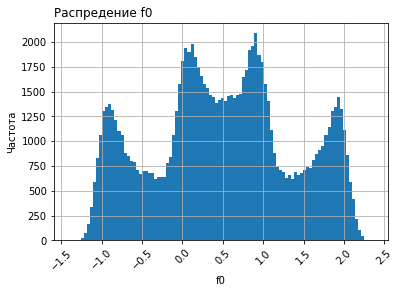

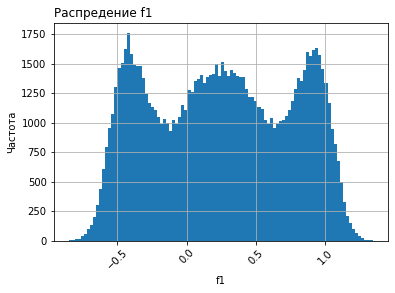

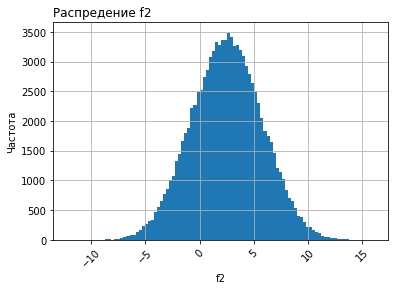

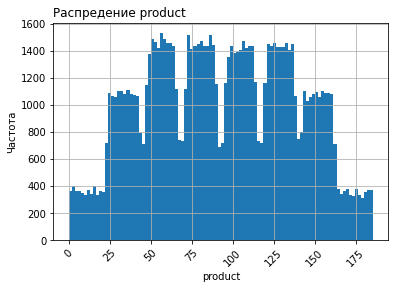

In [22]:
eda(geo_data_0)

Проверим сколько скважин, где объем запасов равен 0. 

In [23]:
geo_data_0[geo_data_0['product']==0]

,id,f0,f1,f2,product
57263,zCM5W,-0.702064,0.375992,0.236572,0.0


Всего это одна скважина.

По распеределениям видим, что f0 имеет четыре моды, f1 три моды, f2 распределено нормально. Признак объем запасов имеет 8 интервалов. Скорее всего в зависимости от комбинации признаков f0, f1 и f2 скважины можно разбать на восемь кластеров по количеству добываемой там нефти.

**Второй регион**

------------- Описательная статистика для числовых данных -------------


,count,mean,std,min,25%,50%,75%,max
f0,99996.0,1.141209,8.965815,-31.609576,-6.298551,1.153055,8.620964,29.421755
f1,99996.0,-4.796608,5.119906,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,99996.0,2.494501,1.703579,-0.018144,1.000021,2.011475,3.999904,5.019721
product,99996.0,68.823916,45.944663,0.000000,26.953261,57.085625,107.813044,137.945408




------------- Гистограммы для числовых признаков -------------


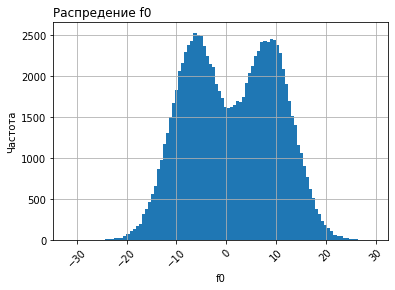

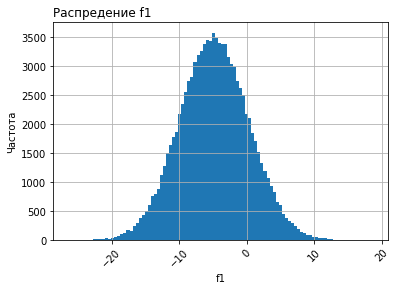

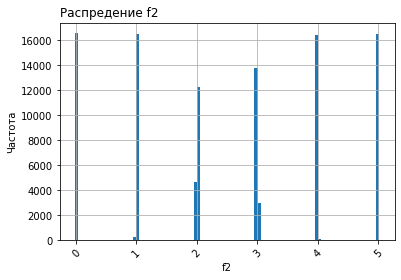

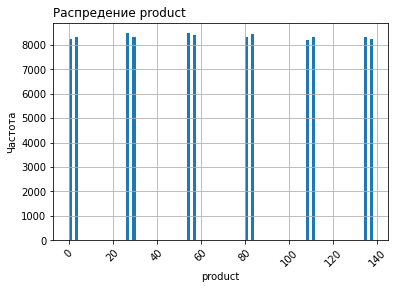

In [24]:
eda(geo_data_1)

Во втором регионе распределения кардинально отличаются от распределений в первом регионе. Распределение f0 имеет две моды, распределение f1 нормальное, распределения f2 и product говорят нам о том, что эти признаки дискретные.

**Третий регион**

------------- Описательная статистика для числовых данных -------------


,count,mean,std,min,25%,50%,75%,max
f0,99996.0,0.002002,1.732052,-8.760004,-1.162328,0.009424,1.158477,7.238262
f1,99996.0,-0.002159,1.730397,-7.084020,-1.174841,-0.009661,1.163523,7.844801
f2,99996.0,2.495084,3.473482,-11.970335,0.130269,2.484236,4.858720,16.739402
product,99996.0,94.998342,44.749573,0.000000,59.450028,94.925026,130.586815,190.029838




------------- Гистограммы для числовых признаков -------------


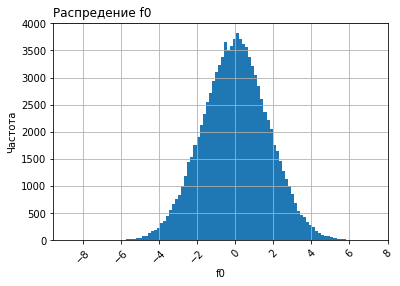

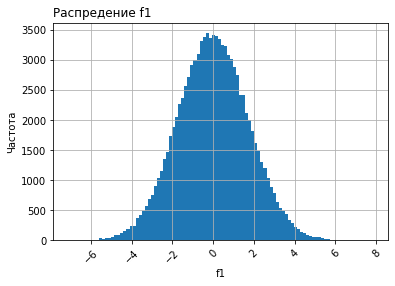

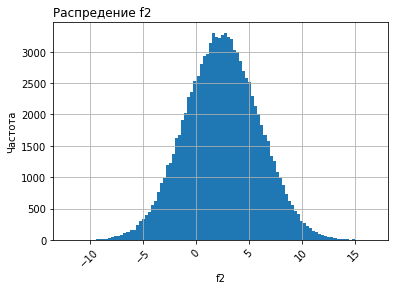

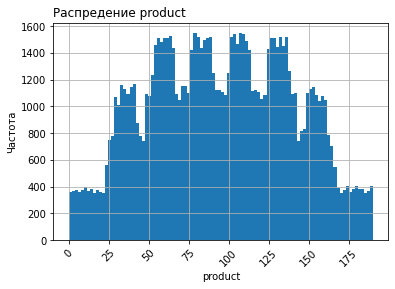

In [25]:
eda(geo_data_2)

Во третьем регионе распределения f0, f1 и f2 нормальные. Объем запасов как и в первом регионе можно разбить на 8 кластеров.

Построим графики рассеяния для каждого признака скважины от объема запасов, чтобы проверить есть ли линейная зависимость.
Напишем функцию.

In [26]:
def scatter(data):
    numeric_features = data.select_dtypes(include='number').columns.tolist()
    numeric_features.remove('product')
    for i in numeric_features:
        sns.scatterplot(data=data, x='product', y=i, label=i)
        plt.title(f'График зависимости {i} от объема запасов', loc = 'left') 
        plt.xlabel('Объем запасов') 
        plt.ylabel(f'{i}') 
        plt.xticks(rotation=45)
        plt.show()

**Первый регион**

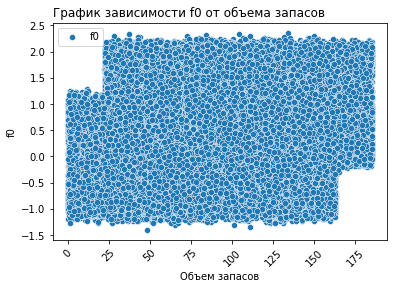

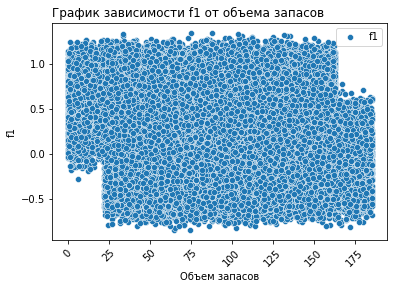

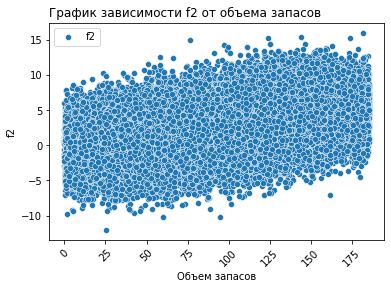

In [27]:
scatter(geo_data_0)

Видим, что в данных для первого региона линейных зависимостей нет. Если модель будет плохо предсказывать объем запасов, то попытаемся применить feature engineering, сделав бинаризацию признаков, либо добавим полиномиальные признаки.

**Второй регион**

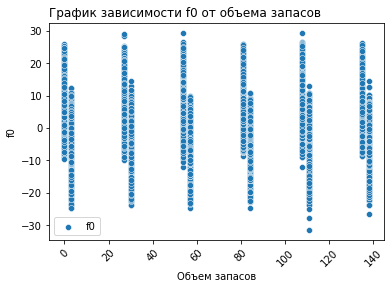

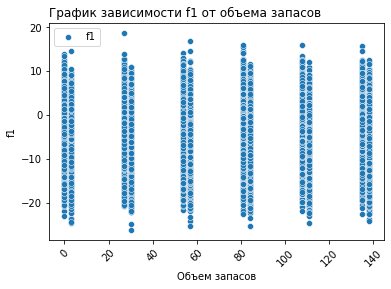

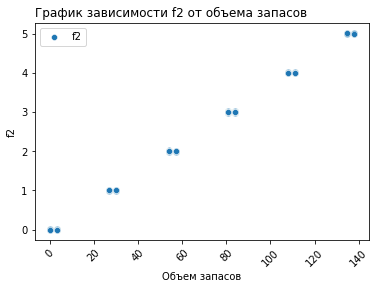

In [28]:
scatter(geo_data_1)

Во втором регионе также видим, что линейные связи, за исключением зависимости f2 от объема запасов, отсутствуют. Скорее всего модель сможет хорошо предсказать целевой признак.

**Третий регион**

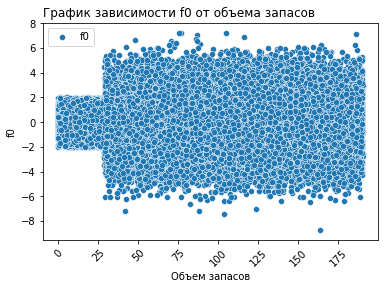

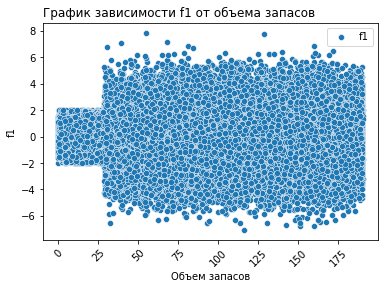

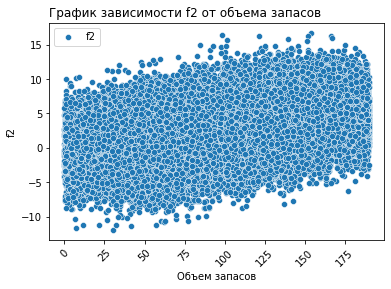

In [29]:
scatter(geo_data_2)

Видим, что в данных для третьего региона линейных зависимостей нет. Если модель будет плохо предсказывать объем запасов, то попытаемся применить feature engineering, сделав бинаризацию признаков или добавим полиномиальные признаки.

Проведем корреляционный анализ. Напишем функцию.

In [30]:
def correlation(data):
    plt.figure(figsize=(10, 5))
    sns.heatmap(data.corr(), annot=True, cmap='coolwarm', vmin=-1)
    plt.title('Корреляция между признаками')
    plt.show()

**Первый регион**

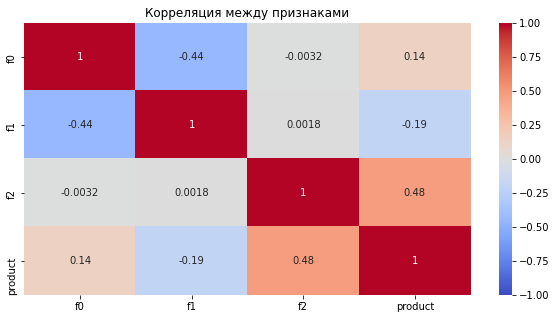

In [31]:
correlation(geo_data_0)

Мультиколлинеарности не наблюдаем. Больше всего с объемом запасов коррелирует f2.

**Второй регион**

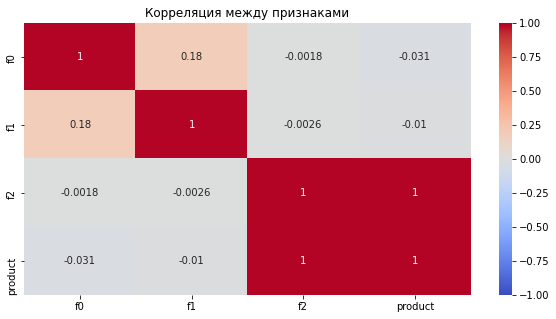

In [32]:
correlation(geo_data_1)

Мультиколлинеарности между входящими признаками не наблюдаем. Больше всего с объемом запасов коррелирует f2, корреляция равна 1, линейная зависимость была видна и на графике рассеяния.

**Третий регион**

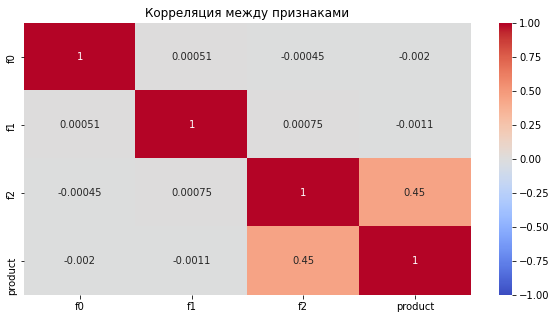

In [33]:
correlation(geo_data_2)

Мультиколлинеарности не наблюдаем. Больше всего с объемом запасов коррелирует f2.

**Промежуточный вывод**


Загрузили три датасета для трех регионов. Изучили общую информацию, убедились в отсутствии пропусков и явных дубликатов. Провели исследовательский анализ данных, построили графики рассеяния для выявления зависимости объема запасов от каждого признака, проверили корреляционный анализ. 


Первый регион.
По распеределениям видим, что f0 имеет четыре моды, f1 три моды, f2 распределено нормально. Признак объем запасов имеет 8 интервалов. Скорее всего в зависимости от комбинации признаков f0, f1 и f2 скважины можно разбать на восемь кластеров по количеству добываемой там нефти. В данных для первого региона линейных зависимостей нет. Если модель будет плохо предсказывать объем запасов, то попытаемся применить feature engineering, сделав бинаризацию признаков или путем добавления полиноминальных признаков. Мультиколлинеарности не наблюдаем. Больше всего с объемом запасов коррелирует f2.


Второй регион.
Во втором регионе распределения кардинально отличаются от распределений в первом регионе. Распределение f0 имеет две моды, распределение f1 нормальное, распределения f2 и product говорят нам о том, что эти признаки дискретные. Во втором регионе также видим, что линейные связи, за исключением зависимости f2 от объема запасов, отсутствуют. Мультиколлинеарности не наблюдаем. Больше всего с объемом запасов коррелирует f2, корреляция равна 1, линейная зависимость была видна и на графике рассеяния.


Третий регион.
Во третьем регионе распределения f0, f1 и f2 нормальные. Объем запасов как и в первом регионе можно разбить на 8 кластеров.  В данных для третьего региона линейных зависимостей нет. Если модель будет плохо предсказывать объем запасов, то попытаемся применить feature engineering, сделав бинаризацию признаков или путем добавления полиноминальных признаков. Мультиколлинеарности не наблюдаем. Больше всего с объемом запасов коррелирует f2.

<a id='section_id2'></a>
## Обучение и проверка модели

Для каждого региона обучим свою модель, поскольку мы помним, что распределения данных отличаются в каждом регионе. Согласно ТЗ для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).

Разобьем данные на обучающую и валидационную выборки в соотношении 75:25.

**Первый регион**

In [34]:
# Входящие признаки
X_0 = geo_data_0.drop(['id', 'product'], axis=1)

In [35]:
# Целевая переменная
y_0 = geo_data_0['product']

In [36]:
# Разбивка на тестовую и валидационную выборки
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X_0, y_0, test_size=0.25, random_state=42)

In [37]:
# Маштабирование данных
scaler = StandardScaler()

In [38]:
X_train_0_scaled = scaler.fit_transform(X_train_0)

In [39]:
X_test_0_scaled = scaler.transform(X_test_0)

В качестве модели используем эластичную модель, Elastic Net сочетает в себе ридж-регрессию и лассо-регрессию, чтобы взять лучшее из обеих регуляризаций.

In [40]:
elastic_model = ElasticNetCV(l1_ratio=[.1, .5, .7,.9, .95, .99, 1],tol=0.01, cv=5, random_state=42)

In [41]:
elastic_model.fit(X_train_0_scaled, y_train_0)

ElasticNetCV(cv=5, l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
             random_state=42, tol=0.01)

In [42]:
elastic_model.l1_ratio_

1.0

In [43]:
test_predictions_0 = elastic_model.predict(X_test_0_scaled)

Проверим качество модели. В качестве метрики используем RMSE и r2.
Метрика R2 (коэффициент детерминации) хороша тем, что помогает оценить качество регрессионной модели, описывающей связь между зависимой и независимыми переменными.

Некоторые преимущества использования R2:

- Показывает, какую часть изменчивости наблюдаемой переменной можно объяснить с помощью построенной модели. Например, если R2 равен 0,72, это означает, что 72% изменений зависимой переменной объясняются изменениями независимой переменной. 
- Позволяет определить, насколько хорошо построенная линия описывает зависимость имеющихся данных. Чем ближе значение R2 к 1, тем точнее линия описывает данные. 
- Используется для оценки производительности модели машинного обучения на основе регрессии. R2 измеряет количество отклонений в прогнозах, объяснённых набором данных, то есть разницу между выборками в наборе данных и прогнозами, сделанными моделью.

In [44]:
MSE = mean_squared_error(y_test_0,test_predictions_0)
RMSE = np.sqrt(MSE)

In [45]:
R2 = r2_score(y_test_0,test_predictions_0)

In [46]:
print('Метрика RMSE на тестовой выборке: ', RMSE)

Метрика RMSE на тестовой выборке:  37.685138841146205


In [47]:
geo_data_0['product'].describe()

count    99990.000000
mean        92.499684
std         44.288304
min          0.000000
25%         56.497069
50%         91.847928
75%        128.563699
max        185.364347
Name: product, dtype: float64

In [48]:
print('Метрика R2 на тестовой выборке: ', R2)

Метрика R2 на тестовой выборке:  0.2745371919183175


Видим, что значения метрик плохие. Ошибка RMSE практически равна стандартному отклонению. Метрика R2 показывает, что только в 27% модель сделала предсказание отличное от среднего значения целевого признака. Коэффициент детерминации оценивает обобщающую способность модели. Это значит, что он определяет, насколько хорошо модель «объясняет», предсказывает целевой признак по входным. Положительные значения R² показывают, в скольких процентах случаев предсказание модели ближе к истине, чем среднее значение целевого признака. Отрицательный R² означает, что средние значения всегда лучше прогнозных.

Визуализируем остатки предсказания модели. Возможно мы сможем выявить какие-то скрытые зависимости в данных.

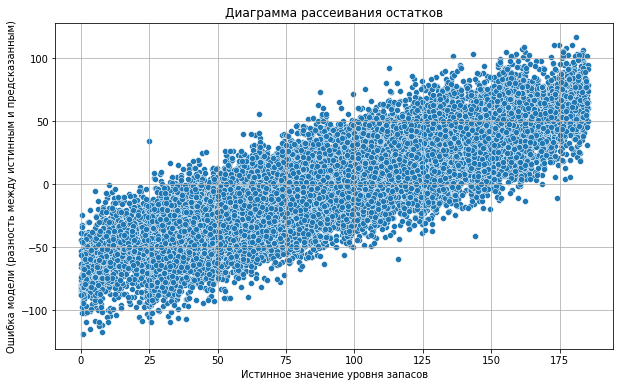

In [49]:
#scater plot по оси Х предсказанные моделью значения, по оси У остатки.
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_0, y=y_test_0 - test_predictions_0)
plt.title('Диаграмма рассеивания остатков')
plt.xlabel('Истинное значение уровня запасов')
plt.ylabel('Ошибка модели (разность между истинным и предсказанным)')
plt.grid(True)
plt.show()

Из графиков делаем вывод, что в данных нет линейных зависимостей, так как остатки не распределены равномерным случайным образом. 

------------- Описательная статистика для числовых данных -------------


,count,mean,std,min,25%,50%,75%,max
f0,99990.0,0.500454,0.871844,-1.408605,-0.072572,0.502405,1.073626,2.362331
f1,99990.0,0.250141,0.504430,-0.848218,-0.200877,0.250252,0.700640,1.343769
f2,99990.0,2.502629,3.248149,-12.088328,0.287784,2.515969,4.715035,16.003790
product,99990.0,92.499684,44.288304,0.000000,56.497069,91.847928,128.563699,185.364347




------------- Гистограммы для числовых признаков -------------


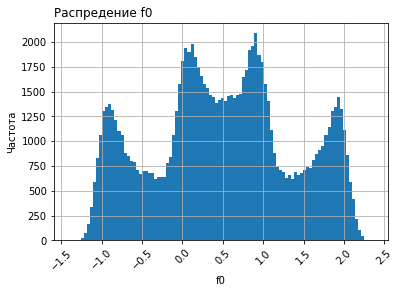

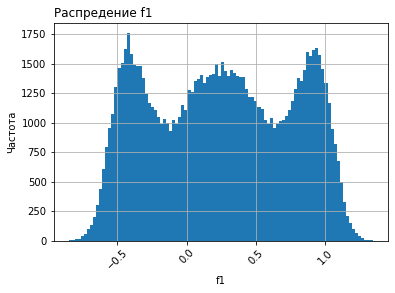

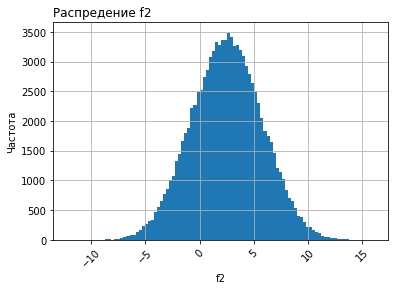

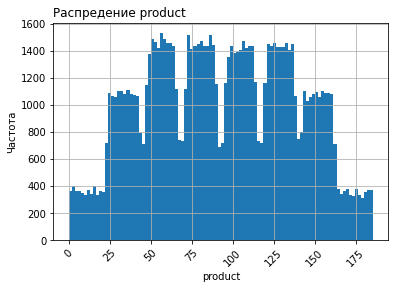

In [50]:
eda(geo_data_0)

Попробуем сделать бинаризацию входящих признаков. Из исследовательского анализа мы помним, что распределения f0 и f1 были многомодальными. Разобем f0 на бины [-2, -0.5, 0.5, 1.5, 2.5 ], а f1 на [-2, -0.1, 0.6, 2].

In [51]:
# Бины для f0.
cut_labels = [1, 2, 3, 4]
cut_bins = [-2, -0.5, 0.5, 1.5, 2.5 ]

geo_data_0['f0_cat'] = pd.cut(geo_data_0['f0'],
                       bins=cut_bins,
                       labels=cut_labels)
geo_data_0.head()

,id,f0,f1,f2,product,f0_cat
0,txEyH,0.705745,-0.497823,1.221170,105.280062,3
1,2acmU,1.334711,-0.340164,4.365080,73.037750,3
2,409Wp,1.022732,0.151990,1.419926,85.265647,3
3,iJLyR,-0.032172,0.139033,2.978566,168.620776,2
4,Xdl7t,1.988431,0.155413,4.751769,154.036647,4


In [52]:
# Бины для f1.
cut_labels = [1, 2, 3]
cut_bins = [-2, -0.1, 0.6, 2]

geo_data_0['f1_cat'] = pd.cut(geo_data_0['f1'],
                       bins=cut_bins,
                       labels=cut_labels)
geo_data_0.head()

,id,f0,f1,f2,product,f0_cat,f1_cat
0,txEyH,0.705745,-0.497823,1.221170,105.280062,3,1
1,2acmU,1.334711,-0.340164,4.365080,73.037750,3,1
2,409Wp,1.022732,0.151990,1.419926,85.265647,3,2
3,iJLyR,-0.032172,0.139033,2.978566,168.620776,2,2
4,Xdl7t,1.988431,0.155413,4.751769,154.036647,4,2


Заново подготовим данные с учетом новых категориальных. Применим кодирование ohe. Сделаем пайплайн.

In [53]:
# Входящие признаки
X_0_transformed = geo_data_0.drop(['id', 'product', 'f0', 'f1'], axis=1)

In [54]:
# Целевая переменная
y_0_transformed = geo_data_0['product']

In [55]:
# Разбивка на тестовую и валидационную выборки
X_train_0_cat, X_test_0_cat, y_train_0_cat, y_test_0_cat = \
train_test_split(X_0_transformed, y_0_transformed, test_size=0.25, random_state=42)

In [56]:
# Список для ohe
ohe_columns = ['f0_cat', 'f1_cat']

In [57]:
# Список для scaler
num_columns = ['f2']

Подготовим пайплайн.

In [58]:
# Cоздаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование, SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )


# Создаем пайплайн для подготовки данных к обучению.
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)


In [59]:
X_train_0_cat = data_preprocessor.fit_transform(X_train_0_cat)

In [60]:
X_test_0_cat = data_preprocessor.transform(X_test_0_cat)

In [61]:
# Обучаем модель
elastic_model.fit(X_train_0_cat,y_train_0_cat)

ElasticNetCV(cv=5, l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
             random_state=42, tol=0.01)

In [62]:
test_predictions_0_cat = elastic_model.predict(X_test_0_cat)

In [63]:
MSE = mean_squared_error(y_test_0_cat,test_predictions_0_cat)
RMSE = np.sqrt(MSE)

In [64]:
R2 = r2_score(y_test_0_cat,test_predictions_0_cat)

In [65]:
print('Метрика RMSE на тестовой выборке: ', RMSE)

Метрика RMSE на тестовой выборке:  37.4893614063164


In [66]:
print('Метрика R2 на тестовой выборке: ', R2)

Метрика R2 на тестовой выборке:  0.2820552918962814


Метрики улучшились, но незначительно.

Попробуем добавить полиноминальные признаки.

In [67]:
# Создадим конвертер
polynomial_converter = PolynomialFeatures(degree=3,include_bias=False)

In [68]:
# Добавим полиномы
poly_features = polynomial_converter.fit_transform(X_0)

In [69]:
# Разбивка на тестовую и валидационную выборки
X_train_0_poly, X_test_0_poly, y_train_0, y_test_0 = train_test_split(poly_features, y_0, test_size=0.25, random_state=42)

In [70]:
# Маштабирование данных
X_train_0_poly_scaled = scaler.fit_transform(X_train_0_poly)

In [71]:
X_test_0_poly_scaled = scaler.transform(X_test_0_poly)

In [72]:
# Обучим модель на новых признаках
elastic_model.fit(X_train_0_poly_scaled, y_train_0)

ElasticNetCV(cv=5, l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
             random_state=42, tol=0.01)

In [73]:
# Предсказание модели
test_predictions_0_poly = elastic_model.predict(X_test_0_poly_scaled)

In [74]:
# Метрика RMSE
MSE = mean_squared_error(y_test_0,test_predictions_0_poly)
RMSE = np.sqrt(MSE)

In [75]:
print('Метрика RMSE на тестовой выборке: ', RMSE)

Метрика RMSE на тестовой выборке:  37.25812646004047


Метрика незначительно, но улучшилась.

Сохраним предсказания и правильные ответы на валидационной выборке.

In [76]:
# Предсказания для первого региона
product_prediction_1_region = pd.Series(test_predictions_0_poly)

In [77]:
# Правильные ответы для первого региона
tru_product_1_region = pd.Series(y_test_0_cat)

Напечатаем на экране средний запас предсказанного сырья и RMSE модели.

In [78]:
print('Средний запас предсказанного сырья для первого региона: ', product_prediction_1_region.mean().round(2))

Средний запас предсказанного сырья для первого региона:  92.64


In [79]:
print('Значение ошибки RMSE для первого региона: ', RMSE.round(2))

Значение ошибки RMSE для первого региона:  37.26


**Промежуточный вывод для первого региона**

При анализе работы модели увидели, что линейная регрессия плохо предсказывает объем запасов. Ошибка составляет более 30% от среднего значения. Для данных явно не подходит модель линейной регрессии. Стоит попробовать ансамбли, но согласно ТЗ должна использоваться только линейная регрессия.

**Второй регион**

In [80]:
# Входящие признаки
X_1 = geo_data_1.drop(['id', 'product'], axis=1)

In [81]:
# Целевая переменная
y_1 = geo_data_1['product']

In [82]:
# Разбивка на тестовую и валидационную выборки
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.25, random_state=42)

In [83]:
# Маштабирование данных
X_train_1_scaled = scaler.fit_transform(X_train_1)

In [84]:
X_test_1_scaled = scaler.transform(X_test_1)

In [85]:
# Обучение модели
elastic_model.fit(X_train_1_scaled, y_train_1)

ElasticNetCV(cv=5, l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
             random_state=42, tol=0.01)

In [86]:
# Предсказания модели
test_predictions_1 = elastic_model.predict(X_test_1_scaled)

Сохраним предсказания и правильные ответы на валидационной выборке.

In [87]:
# Предсказания для второго региона
product_prediction_2_region = pd.Series(test_predictions_1)

In [88]:
# Правильные ответы для второго региона региона
tru_product_2_region = pd.Series(y_test_1)

Напечатаем на экране средний запас предсказанного сырья и RMSE модели.

In [89]:
print('Средний запас предсказанного сырья для второго региона: ', product_prediction_2_region.mean().round(2))

Средний запас предсказанного сырья для второго региона:  68.58


In [90]:
print('Значение ошибки RMSE для второго региона: ', np.sqrt(mean_squared_error(y_test_1,test_predictions_1)).round(2))

Значение ошибки RMSE для второго региона:  0.9


**Промежуточный вывод для второго региона**

При анализе работы модели увидели, что линейная регрессия довольно хорошо предсказывает объем запасов. Ошибка составляет примерно 1,29% от среднего значения. 

**Третий регион**

In [91]:
# Входящие признаки
X_2 = geo_data_2.drop(['id', 'product'], axis=1)

In [92]:
# Целевая переменная
y_2 = geo_data_2['product']

In [93]:
# Разбивка на тестовую и валидационную выборки
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.25, random_state=42)

In [94]:
# Маштабирование данных
X_train_2_scaled = scaler.fit_transform(X_train_2)

In [95]:
X_test_2_scaled = scaler.transform(X_test_2)

In [96]:
# Обучение модели
elastic_model.fit(X_train_2_scaled, y_train_2)

ElasticNetCV(cv=5, l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
             random_state=42, tol=0.01)

In [97]:
# Предсказания модели
test_predictions_2 = elastic_model.predict(X_test_2_scaled)

Сохраним предсказания и правильные ответы на валидационной выборке.

In [98]:
# Предсказания для второго региона
product_prediction_3_region = pd.Series(test_predictions_2)

In [99]:
# Правильные ответы для второго региона региона
tru_product_3_region = pd.Series(y_test_2)

Напечатаем на экране средний запас предсказанного сырья и RMSE модели.

In [100]:
print('Средний запас предсказанного сырья для третьего региона: ', product_prediction_3_region.mean().round(2))

Средний запас предсказанного сырья для третьего региона:  94.94


In [101]:
print('Значение ошибки RMSE для третьего региона: ', np.sqrt(mean_squared_error(y_test_2,test_predictions_2)).round(2))

Значение ошибки RMSE для третьего региона:  40.08


**Промежуточный вывод для первого региона**

При анализе работы модели увидели, что линейная регрессия плохо предсказывает объем запасов. Ошибка составляет примерно 42% от среднего значения. Для данных явно не подходит модель линейной регрессии. Стоит попробовать ансамбли, но согласно ТЗ должна использоваться только линейная регрессия.

**Промежуточный вывод по разделу**

Для каждого региона обучили свою модель, поскольку мы помним, что распределения данных отличаются в каждом регионе. Согласно ТЗ для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые). 
После обучения модели в первом регионе пришли к выводу, что линейная регрессия плохо предсказывает целевой признак. Попробовали поработать с входящими признаками, сделали бины, добавили полиномы, но метрика улучшилась незначительно. Изучили распределение остатков модели, убедились в отсутствии линейных зависимостей.

Для второго же региона линейная регрессия показала себя очень хорошо с небольшой ошибкой. Но мы помним, что признак f2 был линейно зависим от таргета и значение корреляции между ними составляло 1.

Для третьего региона модель отработала еще хуже. Ошибка составила примерно 42% от среднего значения.

<a id='section_id3'></a>
## Подготовка к расчёту прибыли

Бюджет на разработку скважин в регионе — 10 млрд рублей.

При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.


При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.


Создадим переменные.


In [102]:
budget = 10000000000

In [103]:
revenue_barrel = 450000

In [104]:
num_well = 200

Бюджет на разработку одной скважины в регионе с учетом того, что будет выбрано 200 скважин.

In [105]:
budget_well = budget / num_well
budget_well 

50000000.0

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе. 

In [106]:
# Необходимый объем добычи в целом для одного региона, чтобы окупить бюджет.
region_target_product = budget / revenue_barrel
region_target_product

22222.222222222223

Чтобы окупить затраты на разработку региона, в каждом регионе должно добываться не менее 2223 тыс баррелей нефти.

In [107]:
# Необходимый средний объем добычи в каждой скважине.
well_target_product = region_target_product / num_well
well_target_product

111.11111111111111

Каждая скважина должна приносить не менее 112 тыс баррелей нефти. Сравним это значение со средним по каждому региону. Возьмем среднее истинных значений, а затем среднее предсказанных значений.  А затем скорректируем предсказанное среднее в каждом регионе на ошибку.

In [108]:
mean_product_1 = product_prediction_1_region.mean().round(2)

In [109]:
error_1 = 37.59

In [110]:
print('Среднее значение истинного объема добычи в скважине для первого региона: ', tru_product_1_region.mean().round(2))
print('Среднее значение предсказанного объема добычи в скважине для первого региона: ', mean_product_1)
print('Среднее значение предсказанного объема добычи в скважине для первого региона с учетом ошибки: ', mean_product_1-error_1)

Среднее значение истинного объема добычи в скважине для первого региона:  92.39
Среднее значение предсказанного объема добычи в скважине для первого региона:  92.64
Среднее значение предсказанного объема добычи в скважине для первого региона с учетом ошибки:  55.05


In [111]:
mean_product_2 = product_prediction_2_region.mean().round(2)

In [112]:
error_2 = 0.89

In [113]:
print('Среднее значение истинного объема добычи в скважине для второго региона: ', tru_product_2_region.mean().round(2))
print('Среднее значение предсказанного объема добычи в скважине для первого региона: ', mean_product_2)
print('Среднее значение предсказанного объема добычи в скважине для первого региона с учетом ошибки: ', mean_product_2-error_2)

Среднее значение истинного объема добычи в скважине для второго региона:  68.58
Среднее значение предсказанного объема добычи в скважине для первого региона:  68.58
Среднее значение предсказанного объема добычи в скважине для первого региона с учетом ошибки:  67.69


In [114]:
mean_product_3 = product_prediction_3_region.mean().round(2)

In [115]:
error_3 = 40.15

In [116]:
print('Среднее значение истинного объема добычи в скважине для третьего региона: ', tru_product_3_region.mean().round(2))
print('Среднее значение предсказанного объема добычи в скважине для первого региона: ', mean_product_3)
print('Среднее значение предсказанногообъема добычи в скважине для первого региона с учетом ошибки: ', mean_product_3-error_3)

Среднее значение истинного объема добычи в скважине для третьего региона:  95.25
Среднее значение предсказанного объема добычи в скважине для первого региона:  94.94
Среднее значение предсказанногообъема добычи в скважине для первого региона с учетом ошибки:  54.79


**Промежуточный вывод по этапу подготовки расчета прибыли**

Чтобы окупить вложенный бюджет на каждый регион при условии разработки 200 скважин, каждая скважина должна приносить не менее 112 тыс баррелей. 
Мы сравнили этот показатель со средним предсказанным и действительным показателе добычи каждой скважины в каждом регионе. В трех регионах средний показатель добычи на скважину менее необходимого числа 112 тыс баррелей для безубыточной разработки, но мы помним, что истинные объемы запасов не были нормально распределены. Поэтому среднее значение не будет релевантной оценкой.

<a id='section_id4'></a>
## Расчёт прибыли и рисков 

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.

In [143]:
def revenue(tru_product, predicted_product, count, price_barrel, region_budget): # аргументы функции реальный объем, 
    #предсказнный объем, кол-во скважин, цена за 1000 баррелей, бюджет на разработку региона
    predicted_product.index = tru_product.index # присвоим предсказаниям такие же индексы как у реальных значений
    product_sorted = predicted_product.sort_values(ascending=False) # сортировка предсказанного объема по убыванию
    product = tru_product[product_sorted.index][:count] # выбираем самые доходные предсказанные скважины по индексу


    # КОД РЕВЬЮЕРА, DEBUG
    if tru_product[product_sorted.index].shape[0] != product_sorted.shape[0]:
        print(f"Shape mismatch! You took {tru_product[product_sorted.index].shape[0]} target values!")

    turnover = np.sum(price_barrel * product) # подсчет выручки со всех выбранных скважин в регионе
    region_revenue = turnover - region_budget # подсчет прибыли в регионе 
    return region_revenue.round(2)
    

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли. Напишем функцию.

In [145]:
def bootstrap(tru_product, predicted_product):
    state = np.random.RandomState(101)
    values = []
    for i in range(1000):
        predicted_product.index = tru_product.index # присвоим предсказаниям такие же индексы как у реальных значений
        tru_product_subsample = tru_product.sample(n=500, replace=True, random_state=state) # из реальных объемов берем выборку 
        # в 500 скважин
        #tru_product_subsample = tru_product_subsample.reset_index(drop=True)
        predicted_product_subsample = predicted_product[tru_product_subsample.index] # берем выборку с такими же индексами из
        #предсказанных значений
        
        tru_product_subsample = tru_product_subsample.reset_index(drop=True) # сбросим индексы для исключения ситуации с 
        # мультипликацией строк при работе функции для расчета прибыли
        predicted_product_subsample = predicted_product_subsample.reset_index(drop=True) # та же операция по сбросу индекса
        
        values.append(revenue(tru_product_subsample, predicted_product_subsample, 200, revenue_barrel, budget)) # считаем
        #прибыль для каждой выборки, из 500 скважин берем 200 лучших
    values = pd.Series(values)
    return values
    

Для каждого региона найдем распределение прибыли. Для этого применим написанную функцию для техники Bootstrap, найдем среднюю прибыль и 95% доверительный интервал. А также построим графики распределений объемов запасов - истинные, предсказанные, после bootstrap.

Напишем функцию.

In [146]:
def kde(tru_product, predicted_product, bootstrap_product):
    plt.figure(figsize = (12, 5))
    
    plt.subplot(131) # 1 - кол-во строк, 2 - кол-во столбцов, 1 - индекс
    sns.kdeplot(tru_product, label = 'tru_product', fill=True)
    plt.title('Распределение истинных\nобъемов запасов', loc = 'left')

    plt.subplot(132)
    sns.kdeplot(predicted_product, label = 'predicted_product', fill=True)
    plt.title('Распределение предсказанных\nобъемов запасов', loc = 'left')
    
    plt.subplot(133)
    graph= sns.kdeplot(bootstrap_product, label = 'bootstrap_product', fill=True)
    graph.axvline(bootstrap_product.quantile(0.025), color='red')
    graph.axvline(bootstrap_product.quantile(0.975), color='blue')
    plt.title('Распределение прибыли\nзапасов метод bootstrap и доверит.интервал', loc = 'left')
    
    plt.show()

**Первый регион**

In [147]:
bootstrap_values_1_region = bootstrap(tru_product_1_region, product_prediction_1_region)

In [148]:
lower_1 = bootstrap_values_1_region.quantile(0.025).round(2)

In [149]:
higher_1 = bootstrap_values_1_region.quantile(0.975).round(2)

In [150]:
mean_1 = bootstrap_values_1_region.mean().round(2)

In [151]:
print('Средняя прибыль в первом регионе: ', mean_1)
print('Доверительный 95% интервал прибыли в первом регионе: ', lower_1, '-', higher_1)

Средняя прибыль в первом регионе:  454534447.52
Доверительный 95% интервал прибыли в первом регионе:  -54494157.87 - 943225077.31


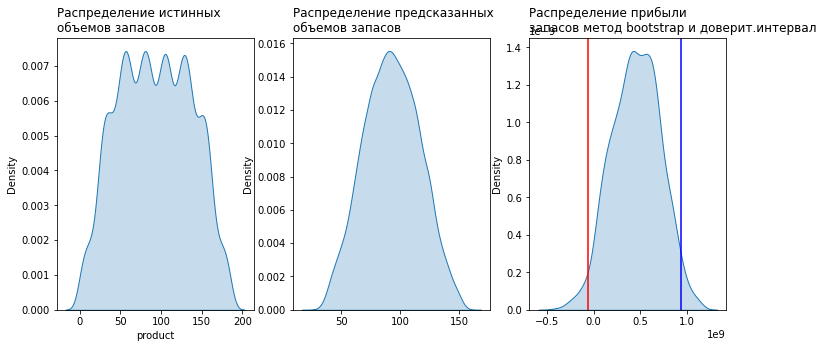

In [152]:
kde(tru_product_1_region, product_prediction_1_region, bootstrap_values_1_region)

Найдем риск убытков. Напишем функцию.

In [153]:
def risk(boootstrap_revenue):
    mu = boootstrap_revenue.mean() # среднее значение распределения
    sigma = boootstrap_revenue.std() # стандартное отклонение распределения
    distr = st.norm(mu, sigma)
    x_0 = 0
    result = distr.cdf(x_0)
    return result

In [154]:
print('Вероятность риска получить убытки  в первом регионе равна: ', (risk(bootstrap_values_1_region) * 100).round(2)\
      , 'процентов')

Вероятность риска получить убытки  в первом регионе равна:  4.01 процентов


**Второй регион**

In [155]:
bootstrap_values_2_region = bootstrap(tru_product_2_region, product_prediction_2_region)

In [156]:
lower_2 = bootstrap_values_2_region.quantile(0.025).round(2)

In [157]:
higher_2 = bootstrap_values_2_region.quantile(0.975).round(2)

In [158]:
mean_2 = bootstrap_values_2_region.mean().round(2)

In [159]:
print('Средняя прибыль вo втором регионе: ', mean_2)
print('Доверительный 95% интервал прибыли во втором регионе: ', lower_2, '-', higher_2)

Средняя прибыль вo втором регионе:  431824241.96
Доверительный 95% интервал прибыли во втором регионе:  34529587.5 - 813904381.83


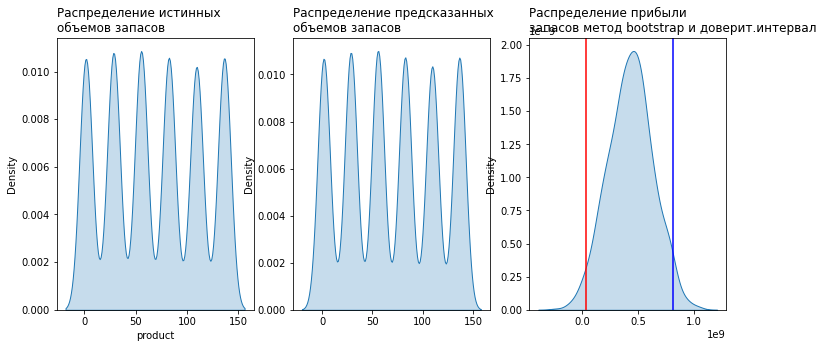

In [160]:
kde(tru_product_2_region, product_prediction_2_region, bootstrap_values_2_region)

In [161]:
print('Вероятность риска получить убытки  во втором регионе равна: ', (risk(bootstrap_values_2_region) * 100).round(2)\
      , 'процентов')

Вероятность риска получить убытки  во втором регионе равна:  1.66 процентов


**Третий регион**

In [162]:
bootstrap_values_3_region = bootstrap(tru_product_3_region, product_prediction_3_region)

In [163]:
lower_3 = bootstrap_values_3_region.quantile(0.025).round(2)

In [164]:
higher_3 = bootstrap_values_3_region.quantile(0.975).round(2)

In [165]:
mean_3 = bootstrap_values_3_region.mean().round(2)

In [166]:
print('Средняя прибыль в третьем регионе: ', mean_3)
print('Доверительный 95% интервал прибыли в третьем регионе: ', lower_3, '-', higher_3)

Средняя прибыль в третьем регионе:  362512438.51
Доверительный 95% интервал прибыли в третьем регионе:  -113691519.34 - 901834337.78


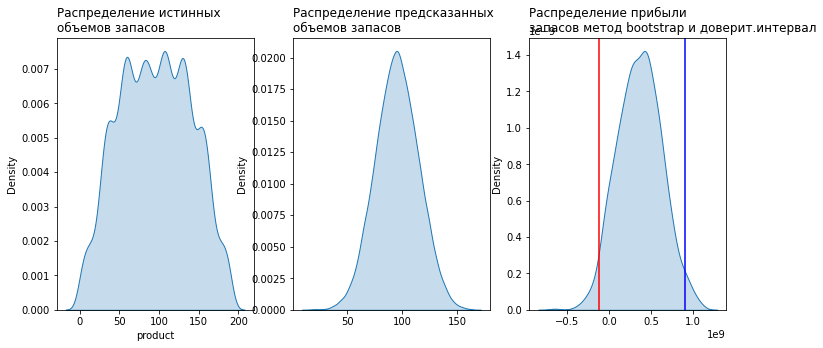

In [167]:
kde(tru_product_3_region, product_prediction_3_region, bootstrap_values_3_region)

In [168]:
print('Вероятность риска получить убытки  в третьем регионе равна: ', (risk(bootstrap_values_3_region) * 100).round(2)\
      , 'процентов')

Вероятность риска получить убытки  в третьем регионе равна:  8.31 процентов


**Промежуточный вывод**

Для расчета прибыли была написана функция, которая по предсказаниям модели находит 200 самых производительных, а затем по индексам из предсказанных значений формирует выборку из реальных значений объема запасов. Затем каждое значение в выборке умножается на стоимость тысячи баррелей (единицы даны в тысячах) и подсчитывается суммарная выручка по региону, из которой затем вычитаются затраты на разработку всего региона.

Далее был применен метод bootstrap для формирования 1000 выборок по 500 наблюдений. Поскольку распределения объемов запасов не были нормальными, то сравнивать среднюю безубыточность одной скважины в 112 баррелей со средним истинным значением объема запасов одной скважины в регионе было бы некорректно. Соответственно мы прибегли к bootstrap, чтобы затем опереться на центральную предельную теорему. Центральная предельная теорема говорит, что все средние всех возможных выборок размера 
n распределены нормально вокруг истинного среднего генеральной совокупности. «Вокруг» означает, что среднее этого распределения всех выборочных средних будет равно истинному среднему значению генеральной совокупности. Дисперсия будет равна дисперсии генеральной совокупности, делённой на n-размер выборки. Благодаря этому мы смогли рассчитать доверительный интервал 95%, а затем риски убытков, опираясь на кумулятивную функцию распределения (CDF) — это вероятность того, что случайная величина примет значение, меньшее или равное определённому числу.

После всех расчетов мы пришли к выводу, что условиям ТЗ, а именно риск убытков не более 2,5% соответствует только второй регион. Поэтому он предлагается как место инвестиций в разработку скважин.

<a id='section_id5'></a>
## Общий вывод


Загрузили три датасета для трех регионов. Изучили общую информацию, убедились в отсутствии пропусков и явных дубликатов. Провели исследовательский анализ данных, построили графики рассеяния для выявления зависимости объема запасов от каждого признака, проверили корреляционный анализ. 


Первый регион.
По распеределениям видим, что f0 имеет четыре моды, f1 три моды, f2 распределено нормально. Признак объем запасов имеет 8 интервалов. Скорее всего в зависимости от комбинации признаков f0, f1 и f2 скважины можно разбать на восемь кластеров по количеству добываемой там нефти. В данных для первого региона линейных зависимостей нет. Если модель будет плохо предсказывать объем запасов, то попытаемся применить feature engineering, сделав бинаризацию признаков или путем добавления полиноминальных признаков. Мультиколлинеарности не наблюдаем. Больше всего с объемом запасов коррелирует f2.


Второй регион.
Во втором регионе распределения кардинально отличаются от распределений в первом регионе. Распределение f0 имеет две моды, распределение f1 нормальное, распределения f2 и product говорят нам о том, что эти признаки дискретные. Во втором регионе также видим, что линейные связи, за исключением зависимости f2 от объема запасов, отсутствуют. Мультиколлинеарности не наблюдаем. Больше всего с объемом запасов коррелирует f2, корреляция равна 1, линейная зависимость была видна и на графике рассеяния.


Третий регион.
Во третьем регионе распределения f0, f1 и f2 нормальные. Объем запасов как и в первом регионе можно разбить на 8 кластеров.  В данных для третьего региона линейных зависимостей нет. Если модель будет плохо предсказывать объем запасов, то попытаемся применить feature engineering, сделав бинаризацию признаков или путем добавления полиноминальных признаков. Мультиколлинеарности не наблюдаем. Больше всего с объемом запасов коррелирует f2.


Для каждого региона обучили свою модель, поскольку мы помним, что распределения данных отличаются в каждом регионе. Согласно ТЗ для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые). 
После обучения модели в первом регионе пришли к выводу, что линейная регрессия плохо предсказывает целевой признак. Попробовали поработать с входящими признаками, сделали бины, добавили полиномы, но метрика улучшилась незначительно. Изучили распределение остатков модели, убедились в отсутствии линейных зависимостей.

Для второго же региона линейная регрессия показала себя очень хорошо с небольшой ошибкой. Но мы помним, что признак f2 был линейно зависим от таргета и значение корреляции между ними составляло 1.

Для третьего региона модель отработала еще хуже. Ошибка составила примерно 42% от среднего значения.


Чтобы окупить вложенный бюджет на каждый регион при условии разработки 200 скважин, каждая скважина должна приносить не менее 112 тыс баррелей. 
Мы сравнили этот показатель со средним предсказанным и действительным показателем добычи каждой скважины в каждом регионе. В трех регионах средний показатель добычи на скважину менее необходимого числа 112 тыс баррелей для безубыточной разработки, но мы помним, что истинные объемы запасов не были нормально распределены. Поэтому среднее значение не будет релевантной оценкой.


Для расчета прибыли была написана функция, которая по предсказаниям модели находит 200 самых производительных, а затем по индексам из предсказанных значений формирует выборку из реальных значений объема запасов. Затем каждое значение в выборке умножается на стоимость тысячи баррелей (единицы даны в тысячах) и подсчитывается суммарная выручка по региону, из которой затем вычитаются затраты на разработку всего региона.

Далее был применен метод bootstrap для формирования 1000 выборок по 500 наблюдений. Поскольку распределения объемов запасов не были нормальными, то сравнивать среднюю безубыточность одной скважины в 112 баррелей со средним истинным значением объема запасов одной скважины в регионе было бы некорректно. Соответственно мы прибегли к bootstrap, чтобы затем опереться на центральную предельную теорему. Центральная предельная теорема говорит, что все средние всех возможных выборок размера 
n распределены нормально вокруг истинного среднего генеральной совокупности. «Вокруг» означает, что среднее этого распределения всех выборочных средних будет равно истинному среднему значению генеральной совокупности. Дисперсия будет равна дисперсии генеральной совокупности, делённой на n-размер выборки. Благодаря этому мы смогли рассчитать доверительный интервал 95%, а затем риски убытков, опираясь на кумулятивную функцию распределения (CDF) — это вероятность того, что случайная величина примет значение, меньшее или равное определённому числу.

После всех расчетов мы пришли к выводу, что условиям ТЗ, а именно риск убытков не более 2,5% соответствует только второй регион. Поэтому он предлагается как место инвестиций в разработку скважин.


